In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [42]:
lena_im = Image.open('data/lena_gray.bmp')

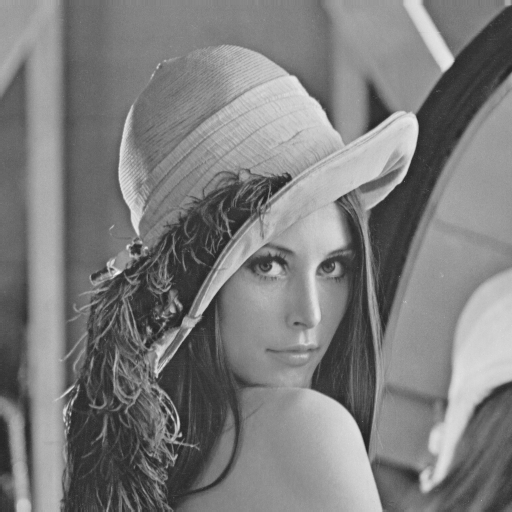

In [155]:
lena_im

In [44]:
lena_arr = np.array(lena_im)

In [55]:
lena_hist = np.unique(lena_arr, return_counts=True)

In [156]:
P = np.zeros(2**8)
P[lena_hist[0]] = lena_hist[1]/lena_arr.size
domain = np.arange(0, 2**8, 1)

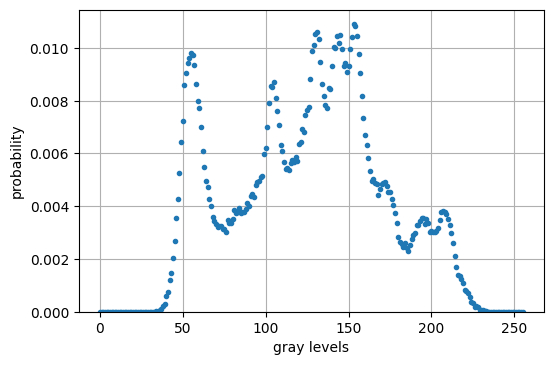

In [157]:
plt.figure(dpi=100)
plt.plot(domain, P, '.')
plt.xlabel('gray levels')
plt.ylabel('probability')
plt.ylim(bottom=0)
plt.grid()
plt.savefig('plots/lena_dist.png')
plt.show()

In [184]:
def MSE(x, Qx, P):
    return np.sum((x - Qx)**2*P)

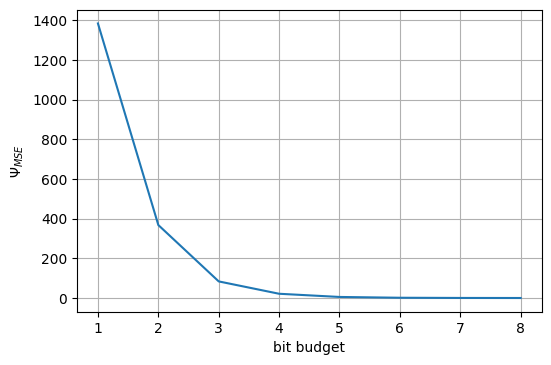

In [186]:
b_range = np.arange(1,9,1)
phi = domain
MSE_vec = np.zeros(8)
for b in b_range:
    delta = 2**(8-b)
    Qphi = (np.floor(phi/delta)+1/2)*delta
    MSE_vec[b-1] = MSE(phi, Qphi, P)
plt.figure(dpi=100)
plt.plot(b_range, MSE_vec, '-')
plt.xlabel('bit budget')
plt.ylabel(r'$\Psi_{MSE}$')
plt.grid()
plt.savefig('plots/MSE_b.png')
plt.show()

In [201]:
def plot_fig_quantization(x, r, q):
    fig = plt.figure(dpi=100)
    plt.plot(x, x, label='identity')
    plt.vlines(r,ymin=np.min(x),ymax=np.max(x), linestyles='dashed', colors='darkorange', label='decision levels')
    legend=True
    for i in range(len(r)-1):
        interval = (domain >= r[i]) & (domain < r[i+1])
        interval_len = np.sum(interval)
        if legend:
            plt.plot(x[interval], np.ones(interval_len)*q[i], label='representation levels', color='darkgreen')
            legend = False
        else:
            plt.plot(x[interval], np.ones(interval_len)*q[i], color='darkgreen')
    plt.ylim((np.min(x), np.max(x)))
    plt.xlim((np.min(x), np.max(x)))
    plt.xlabel('original values')
    plt.ylabel('identity and quantized values')
    plt.grid()
    plt.legend(bbox_to_anchor=(1.02,1.28))

    return fig
    

In [202]:
def plot_b_quantization(b):
    x = domain
    delta = 2**(8-b)
    Qx = (np.floor(x/delta)+1/2)*delta
    deltas = np.arange(0, 2**8+1, delta)

    fig = plot_fig_quantization(x, r=deltas, q=np.unique(Qx))
    plt.figure(fig)
    plt.xlabel('gray level')
    plt.savefig(f'plots/quntization_b_{b}.png', bbox_inches='tight')
    plt.show()

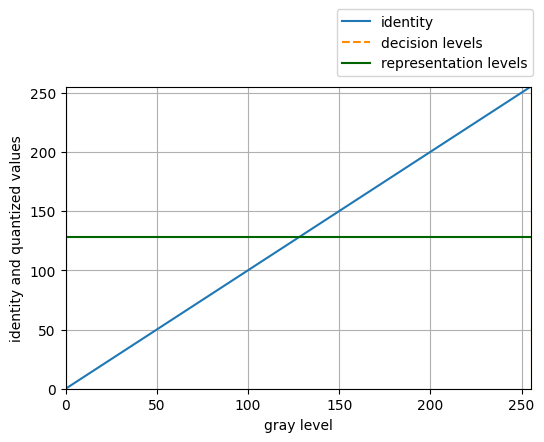

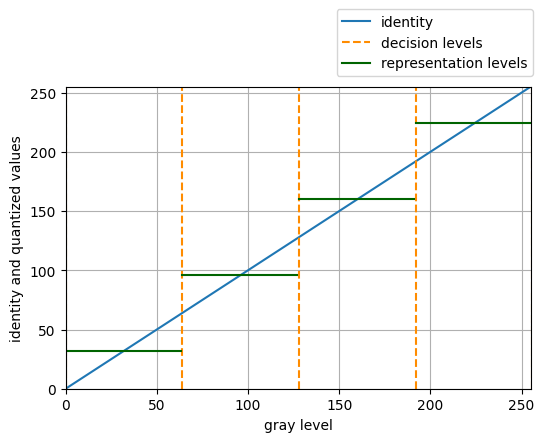

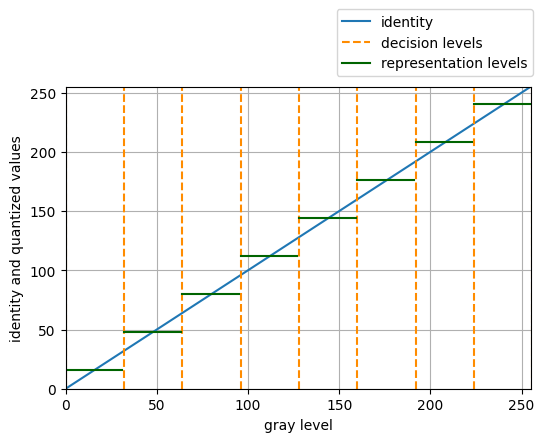

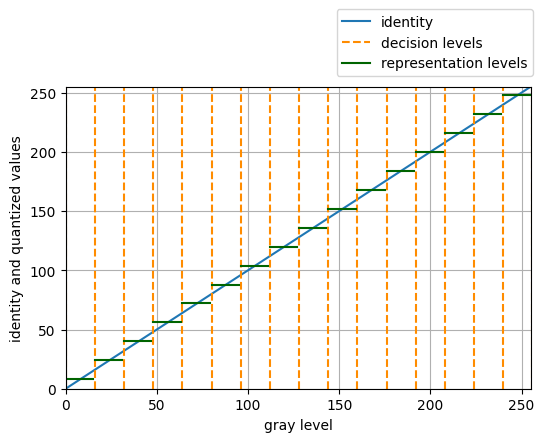

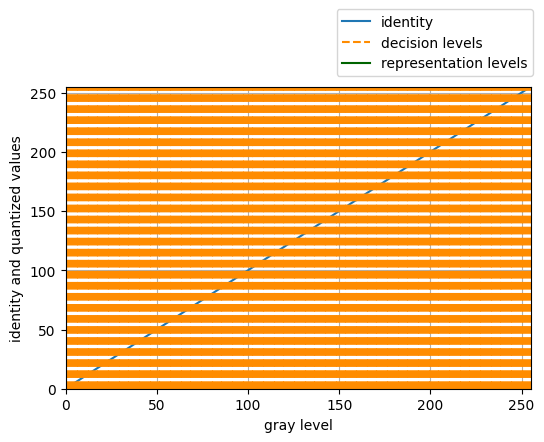

In [203]:

plot_b_quantization(b=0)
plot_b_quantization(b=2)
plot_b_quantization(b=3)
plot_b_quantization(b=4)
plot_b_quantization(b=8)

In [182]:
"""
a function implementing the Max-Lloyd algorithm for discrete distributions.
"""
def max_lloyd(hist, r0, eps=0.5):
    def mse(domain, P, q, r):
        err = 0
        for i in range(len(r)-1):
            interval = (domain >= r[i]) & (domain < r[i+1])
            err += np.sum(((q[i]-domain)**2 * P)[interval])
        
        return err
    
    def step(domain, P, q, r):
        for i in range(len(r)-1):
            interval = (domain >= r[i]) & (domain < r[i+1])
            q[i] = np.sum((domain*P)[interval])/np.sum(P[interval])
        
        for i in range(len(q)-1):
            r[i+1] = (q[i] + q[i+1]) / 2

    domain = np.array(hist[0])
    P = np.array(hist[1])
    L = np.min(domain)
    H = np.max(domain)

    if not np.all(r0[:-1] <= r0[1:]):
        raise ValueError("r0 is not sorted.")

    if r0[0] != L or r0[-1] != H+1:
        raise ValueError("first and last values of r0 must be the lowest and highest values in the domain of the histogram.")

    # intervals with 0 probability are problematic, so we perturb the pdf by a small amount
    num_perturb = np.sum(P==0)
    perturbation = np.min(P[P!=0])*1e-3/num_perturb
    P[P==0] = perturbation
    P /= np.sum(P)

    q = np.zeros(len(r0)-1)
    r = np.array(r0)
    
    step(domain, P, q, r)
    err_prev = mse(domain, P, q, r)
    step(domain, P, q, r)
    err = mse(domain, P, q, r)
    while np.abs(err_prev - err) > eps:
        err_prev = err
        step(domain, P, q, r)
        err = mse(domain, P, q, r)

    return r, q

In [208]:
max_lloyd_mse = np.zeros(8)
for b in range(1,9):
    delta = 2**(8-b)
    deltas = np.arange(0, 2**8+1, delta)
    r, q = max_lloyd([domain, P], deltas, eps=1e-3)
    Qx = np.zeros(len(domain))
    for i in range(len(r)-1):
                interval = (domain >= r[i]) & (domain < r[i+1])
                Qx[interval] = q[i]
    max_lloyd_mse[b-1] = MSE(domain, Qx, P)

b_range = np.arange(1,9,1)
phi = domain
MSE_vec = np.zeros(8)
for b in b_range:
    delta = 2**(8-b)
    Qphi = (np.floor(phi/delta)+1/2)*delta
    MSE_vec[b-1] = MSE(phi, Qphi, P)
plt.figure(dpi=100)
plt.plot(b_range, MSE_vec, '-', label='uniform')
plt.plot(b_range, max_lloyd_mse, '-', label='max-lloyd')
plt.xlabel('bit budget')
plt.ylabel(r'$\Psi_{MSE}$')
plt.grid()
plt.savefig('plots/MSE_max_lloyd.png')
plt.show()

/tmp/ipykernel_815/3258027538.py:16: RuntimeWarning: invalid value encountered in double_scalars
  q[i] = np.sum((domain*P)[interval])/np.sum(P[interval])


ValueError: cannot convert float NaN to integer